# Does gender affect the potential correlation between the age of players and their average game session length?

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

Minecraft is a popular game played universally around the world while simultaneously collecting astonishing amounts of game related data. This unique game is enjoyed by all types of demographics from many countries around the globe. Naturally, understanding user engagement is a fundamental aspect of game development and player analytics. This consequently allows developers to tailor their games towards financial success and ultimately a better user-experience. In this project, we investigate whether there is a relationship between a player’s age and the amount of time they spend playing Minecraft. More specifically, we would like to understand whether male and female players' age can predict their average session time when they play. Overall, the aim is to determine whether a male and female players’ age can help game developers anticipate how long different age groups are likely to stay engaged in a gaming session in order to discover insights on how they can better model their game development toward an optimal age group based on gender.

To explore this question, we use two datasets, namely the players.csv which contains demographic information such as age, gender, and a unique player identifier (hashedEmail); and sessions.csv which contains gameplay session information including start time and end time for each session. The hashedEmail is a unique identifier for each player which is the necessary link required between the two data sets to relate age and session times. Thus, these datasets are merged using hashedEmail to align each player’s demographic data with their session history. For this research question, the variables “Gender”, “Age” and “hashedEmail” in the players data set and the variables “hashedEmail”, “start_time” and “end_time” in the sessions data set will be required for the analysis. The “age” data column is a continuous variable that is already given in the player data set; however, session length is a continuous variable that will have to be calculated based on start and end times from the sessions data set. Finally, we will provide three separate analyses for Males, Females, and all genders in order to give a deeper and more meaningful insight for the stakeholders into the game’s user demographic play habits.


## Loading data

We loaded the data from a google drive url that enabled direct downloading of the two csv files.

In [2]:
# Read the data sets
url_player = "https://drive.google.com/uc?export=download&id=1Meq7x7NGapAcI-wvLSbNRLFo9mDHRP4G"
url_session = "https://drive.google.com/uc?export=download&id=1xXPpX1fZfB1ZZ-fveagW71O3B9c8s0CM"
players <- read_csv(url_player)
sessions <- read_csv(url_session)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Wrangle data

We performed the following wrangling to the data: 

For sessions data:
    - Using mutate() combined with dmy_hm() function to convert the start_time and end_time columns into datetime formats.
    - Calculated the duration of each session by using start_time - end_time, and removed all NA values.
    - Selected only hashedEmail and duration in the cleaned dataframe.
    - Grouped the sessions by hashedEmail, and calculated the mean duration for each hashedEmail that represent a unique player.
    
For players data:
    - Using hashedEmail as the unique identifier, combined the data for the mean session time calculated in the sessions data with other data (i.e. age, gender) for each player
    - Filtered every column in the new dataframe except gender, age, and mean session time.

Using the final dataframe created by combining sessions and players data using the methods listed above, we further filtered the data into a new dataframe such that the new dataframe contains only data for male players. We repeat the process for females and all genders aswell.

In [3]:
sessions_time <- sessions |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))

sessions_clean <- sessions_time |>
    mutate(duration_min = as.double(end_time - start_time, units = "mins")) |>
    filter(!is.na(duration_min)) |>
    select(hashedEmail, duration_min)

sessions_average <- sessions_clean |>
    group_by(hashedEmail) |>
    summarise(mean_session_time = mean(duration_min, na.rm = TRUE), .groups = "drop")

all_sessions <- players |>
    inner_join(sessions_average, by = "hashedEmail") |>
    select(gender, Age, mean_session_time) |>
    drop_na()

male_with_sessions <- all_sessions |> filter(gender == "Male")

female_with_sessions <- all_sessions |> filter(gender == "Female")

head(male_with_sessions)

head(female_with_sessions)

head(all_sessions)

gender,Age,mean_session_time
<chr>,<dbl>,<dbl>
Male,9,74.77778
Male,17,85.00000
Male,17,5.00000
Male,21,9.00000
Male,21,5.00000
Male,17,13.00000


gender,Age,mean_session_time
<chr>,<dbl>,<dbl>
Female,21,50.00000
Female,23,38.33333
Female,25,101.00000
Female,17,87.35135
Female,17,12.00000
Female,21,50.00000


gender,Age,mean_session_time
<chr>,<dbl>,<dbl>
Male,9,74.77778
Male,17,85.00000
Male,17,5.00000
Female,21,50.00000
Male,21,9.00000
Male,21,5.00000


## Split the data into training set and testing set.

We decided to split the training set and the testing set for both male data and all data with a proportion of 8:2, with 80% training set and 20% testing set. For the purpose of cross-validation for KNN, we further performed a 5-fold split on the training set on both data.

In [4]:
set.seed(114514)

# Splitting data for the male gender
male <- male_with_sessions |>
  select(Age, mean_session_time)
male_split <- initial_split(male, prop = 0.8)
male_train <- training(male_split)
male_test <- testing(male_split)
male_rec <- recipe(mean_session_time ~ Age, data = male_train) |>
   step_scale(all_predictors()) |> step_center(all_predictors())
male_vfold <- vfold_cv(male_train, v = 5)

# Splitting data for all genders
all <- all_sessions |>
  select(Age, mean_session_time)
all_split <- initial_split(all, prop = 0.8)
all_train <- training(all_split)
all_test <- testing(all_split)
all_rec <- recipe(mean_session_time ~ Age, data = all_train) |>
  step_scale(all_predictors()) |> step_center(all_predictors())
all_vfold <- vfold_cv(all_train, v = 5)

# Split the female dataset
female <- female_with_sessions |>
  select(Age, mean_session_time)

female_split <- initial_split(female, prop = 0.8)
female_train <- training(female_split)
female_test <- testing(female_split)

# Create a recipe for scaling and centering predictors
female_rec <- recipe(mean_session_time ~ Age, data = female_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# 5-fold cross-validation on the training set
female_vfold <- vfold_cv(female_train, v = 5)

## Predicting mean session time using age with male data only

## Determine best K for KNN

For KNN regression, we need to first determine an optimal K value such that it neither underfits nor overfits the data. After carefully inspected the change in RMSE when increasing the number of neighbours, we decided to pick 3 as our optimal K value for male data.

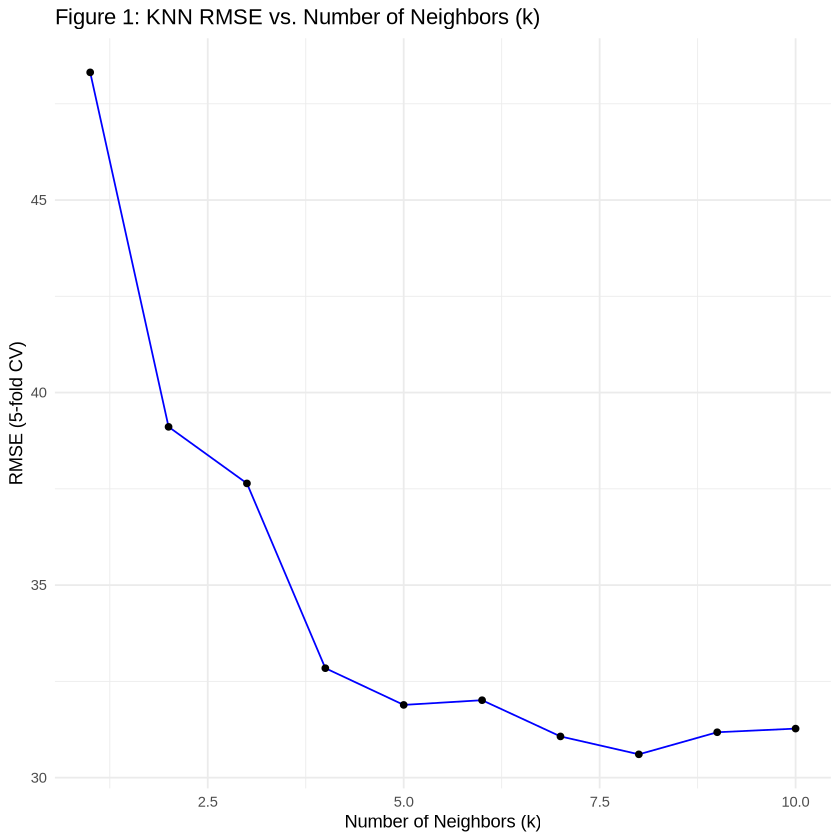

In [17]:
knn_tune_male <- nearest_neighbor(mode = "regression", neighbors = tune()) |> set_engine("kknn")
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
knn_tuned_result_male <- workflow() |>
      add_recipe(male_rec) |>
      add_model(knn_tune_male) |>
      tune_grid(resamples = male_vfold, grid = k_vals) |>
      collect_metrics()
tune_male_plot <- knn_tuned_result_male |> filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue") +
  geom_point() +
  labs(title = "Figure 1: KNN RMSE vs. Number of Neighbors (k)",x = "Number of Neighbors (k)", y = "RMSE (5-fold CV)") + theme_minimal()
tune_male_plot
best_k = 3

## Predicting the data using linear and KNN regression

In this step, we constructed a KNN model and a linear model using the training set that we determined earlier. Then we applied the model to our entire data set to inspect the results.

In [18]:
lm_model <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")
lm_workflow_male <- workflow() |>
  add_recipe(male_rec) |>
  add_model(lm_model) |>
  fit(data = male_train)

knn_model_male <- nearest_neighbor(neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("regression")
knn_workflow_male <- workflow() |>
  add_recipe(male_rec) |> 
  add_model(knn_model_male) |>
  fit(data = male_train)

lm_preds_male <- predict(lm_workflow_male, male) |>
  bind_cols(male) |>
  mutate(model = "Linear Regression")
knn_preds_male <- predict(knn_workflow_male, male) |>
  bind_cols(male) |>
  mutate(model = "KNN")

all_preds_male <- bind_rows(lm_preds_male, knn_preds_male)

## Visualization of KNN vs. Linear Regression

It seems that neither the KNN model nor the linear model is capable of closely fitting a data set that is this scattered. Both lines of regression was heavily affected by the outliers, showing a generally weak, positive relation between the mean session time and player age.

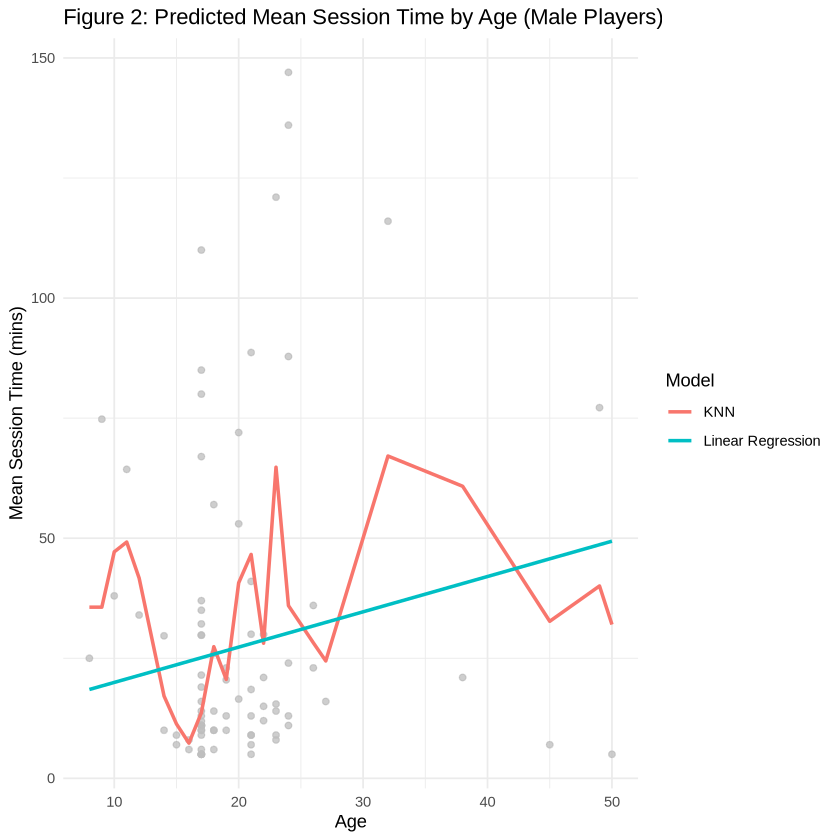

In [19]:
ggplot(all_preds_male, aes(x = Age, y = mean_session_time)) +
  geom_point(alpha = 0.5, color = "gray") +
  geom_line(aes(y = .pred, color = model), size = 1) +
  labs(title = "Figure 2: Predicted Mean Session Time by Age (Male Players)", x = "Age", y = "Mean Session Time (mins)", color = "Model") + theme_minimal()

## Predicting mean session time using age with female data only

## Finding the best K value for our KNN model

For KNN regression, we need to first determine an optimal K value such that it neither underfits nor overfits the data. After carefully inspected the change in RMSE when increasing the number of neighbours, we decided to pick 3 as our optimal K value for male data.

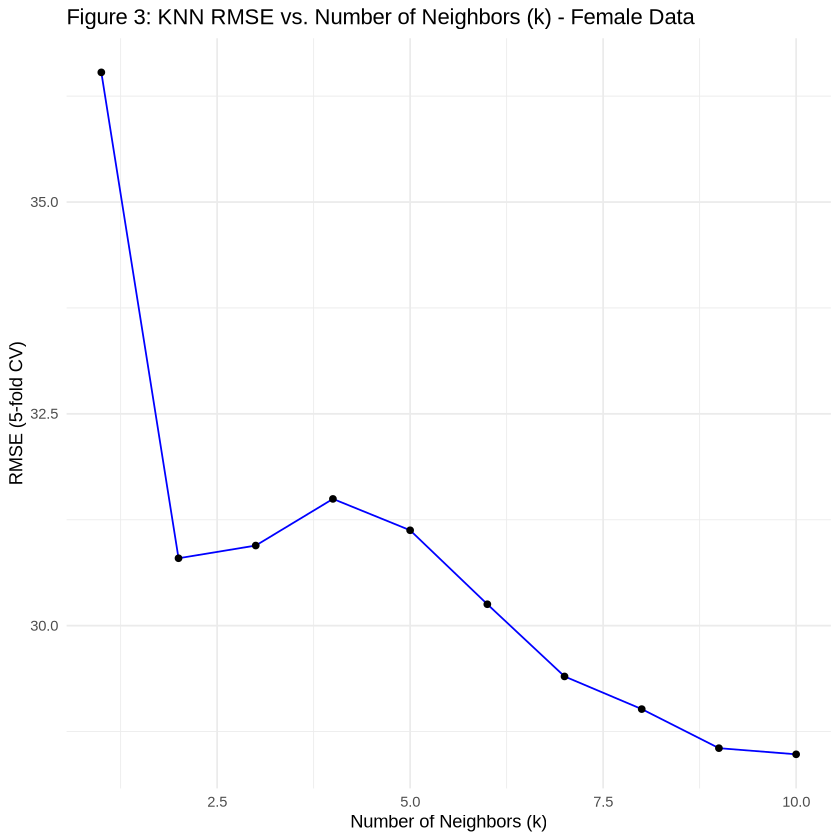

In [20]:
knn_tune_female <- nearest_neighbor(mode = "regression", neighbors = tune()) |> 
  set_engine("kknn")
  
k_vals_female <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_tuned_result_female <- workflow() |>
  add_recipe(female_rec) |>
  add_model(knn_tune_female) |>
  tune_grid(resamples = female_vfold, grid = k_vals_female) |>
  collect_metrics()

tune_female_plot <- knn_tuned_result_female |> 
  filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue") +
  geom_point() +
  labs(title = "Figure 3: KNN RMSE vs. Number of Neighbors (k) - Female Data",
       x = "Number of Neighbors (k)",
       y = "RMSE (5-fold CV)") +
  theme_minimal()

tune_female_plot

best_k_female <- 3

## Doing KNN & Regression Analysis for the female gender

In this step, we constructed a KNN model and a linear model using the training set that we determined earlier. Then we applied the model to our entire data set to inspect the results.

In [21]:
# 1. Specify the models
lm_model_female <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

knn_model_female <- nearest_neighbor(neighbors = best_k_female) |>
  set_engine("kknn") |>
  set_mode("regression")

# 2. Build and fit workflows
lm_workflow_female <- workflow() |>
  add_recipe(female_rec) |>
  add_model(lm_model_female) |>
  fit(data = female_train)

knn_workflow_female <- workflow() |>
  add_recipe(female_rec) |>
  add_model(knn_model_female) |>
  fit(data = female_train)

# 3. Generate predictions on the full female dataset
lm_preds_female <- predict(lm_workflow_female, female) |>
  bind_cols(female) |>
  mutate(model = "Linear Regression")

knn_preds_female <- predict(knn_workflow_female, female) |>
  bind_cols(female) |>
  mutate(model = "KNN")

# 4. Combine predictions for comparison
all_preds_female <- bind_rows(lm_preds_female, knn_preds_female)

## Visualization of KNN model vs. Regression model for female gender

It seems that neither the KNN model nor the linear model is capable of closely fitting a data set that is this scattered. Both lines of regression was heavily affected by the outliers, showing a generally weak, negative relation between the mean session time and player age.

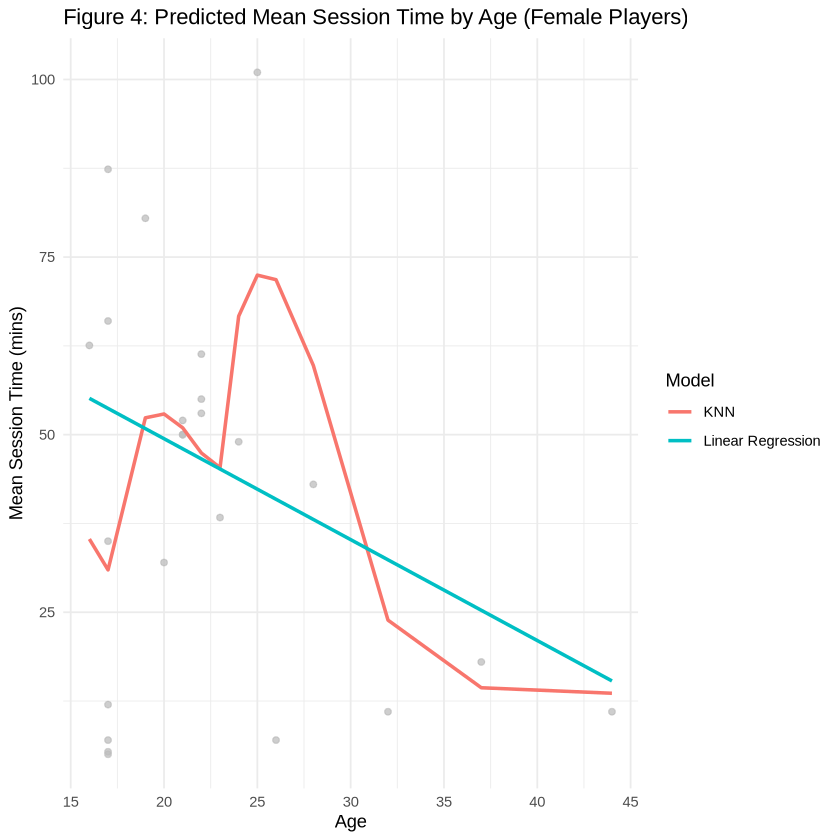

In [22]:
ggplot(all_preds_female, aes(x = Age, y = mean_session_time)) +
  geom_point(alpha = 0.5, color = "gray") +
  geom_line(aes(y = .pred, color = model), size = 1) +
  labs(
    title = "Figure 4: Predicted Mean Session Time by Age (Female Players)",
    x     = "Age",
    y     = "Mean Session Time (mins)",
    color = "Model"
  ) +
  theme_minimal()

## Predicting mean session time using age using data from all genders

## Determine best K for KNN

For KNN regression, we need to first determine an optimal K value such that it neither underfits nor overfits the data. After carefully inspected the change in RMSE when increasing the number of neighbours, we decided to pick 3 as our optimal K value for male data.

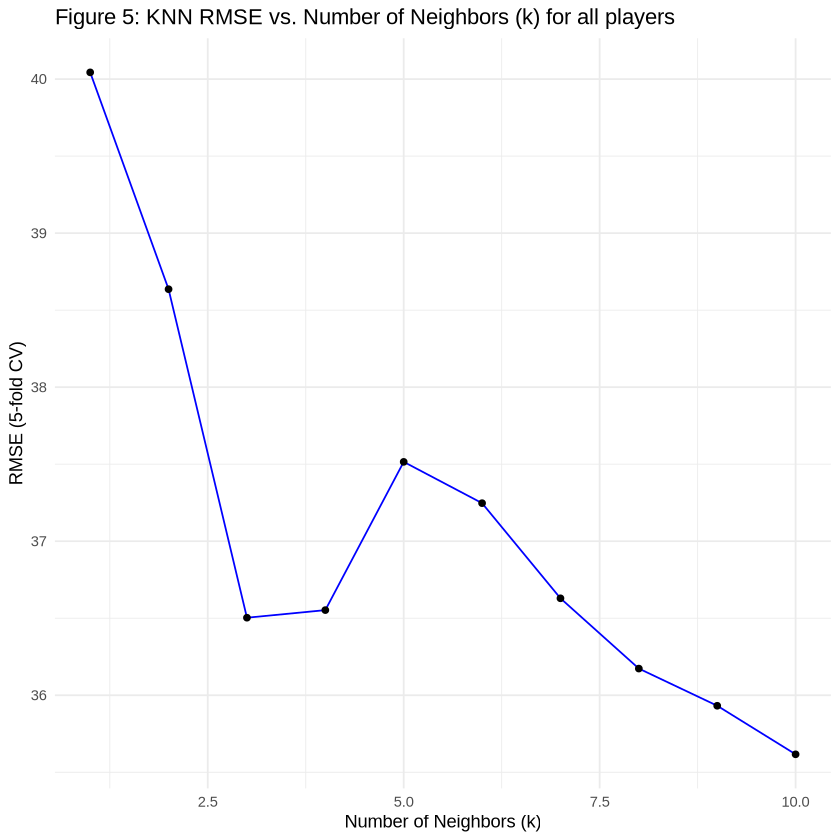

In [23]:
knn_tune_all <- nearest_neighbor(mode = "regression", neighbors = tune()) |> set_engine("kknn")
knn_results_all <- workflow() |>
      add_recipe(all_rec) |>
      add_model(knn_tune_all) |>
      tune_grid(resamples = all_vfold, grid = k_vals) |>
      collect_metrics()
knn_results_all |> filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue") +
  geom_point() +
  labs(title = "Figure 5: KNN RMSE vs. Number of Neighbors (k) for all players",x = "Number of Neighbors (k)", y = "RMSE (5-fold CV)") + theme_minimal()
best_k_all = 3

## Predicting the data using linear and KNN regression

In this step, we constructed a KNN model and a linear model using the training set that we determined earlier. Then we applied the model to our entire data set to inspect the results.

In [24]:
lm_workflow_all <- workflow() |>
  add_recipe(all_rec) |>
  add_model(lm_model) |>
  fit(data = all_train)

knn_model_all <- nearest_neighbor(neighbors = best_k_all) |>
  set_engine("kknn") |>
  set_mode("regression")
knn_workflow_all <- workflow() |>
  add_recipe(all_rec) |>
  add_model(knn_model_all) |>
  fit(data = all_train)

lm_preds_all <- predict(lm_workflow_all, all) |>
  bind_cols(all) |>
  mutate(model = "Linear Regression")
knn_preds_all <- predict(knn_workflow_all, all) |>
  bind_cols(all) |>
  mutate(model = "KNN")
all_model_preds <- bind_rows(lm_preds_all, knn_preds_all)

## Visualization of KNN vs. Linear Regression

Compared to the data that consists of only the male players, it seems that our predictions are still heavily affected by outliers, also showing a generally weak, positive relation between the mean session time and player age. However, the graph for all data seemed to be even more scattered compared to the data with only male players.

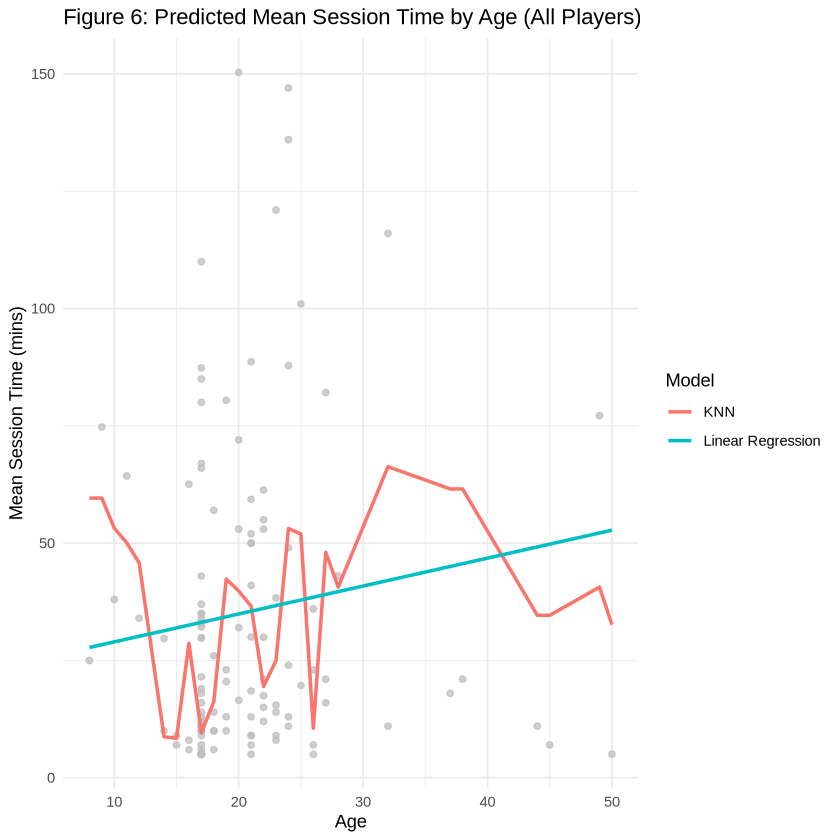

In [25]:
ggplot(all_model_preds, aes(x = Age, y = mean_session_time)) +
  geom_point(alpha = 0.5, color = "gray") +
  geom_line(aes(y = .pred, color = model), size = 1) +
  labs(title = "Figure 6: Predicted Mean Session Time by Age (All Players)", x = "Age", y = "Mean Session Time (mins)", color = "Model") + theme_minimal()

## Forming a table about RMSE & RMSPE information for different gender groups with different analysis models

In [26]:
lm_rmse_female <- lm_workflow_female |>
  predict(new_data = female_train) |>
  bind_cols(female_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
lm_rmspe_female <- lm_workflow_female |>
  predict(new_data = female_test) |>
  bind_cols(female_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmse_female <- knn_workflow_female |>
  predict(new_data = female_train) |>
  bind_cols(female_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmspe_female <- knn_workflow_female |>
  predict(new_data = female_test) |>
  bind_cols(female_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
lm_rmse_male <- lm_workflow_male |>
  predict(new_data = male_train) |>
  bind_cols(male_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
lm_rmspe_male <- lm_workflow_male |>
  predict(new_data = male_test) |>
  bind_cols(male_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
lm_rmse_all <- lm_workflow_all |>
  predict(new_data = all_train) |>
  bind_cols(all_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
lm_rmspe_all <- lm_workflow_all |>
  predict(new_data = all_test) |>
  bind_cols(all_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmse_male <- knn_workflow_male |>
  predict(new_data = all_train) |>
  bind_cols(all_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmspe_male <- knn_workflow_male |>
  predict(new_data = all_test) |>
  bind_cols(all_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmse_all <- knn_workflow_all |>
  predict(new_data = all_train) |>
  bind_cols(all_train) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)
knn_rmspe_all <- knn_workflow_all |>
  predict(new_data = all_test) |>
  bind_cols(all_test) |>
  metrics(truth = mean_session_time, estimate = .pred) |>
  filter(.metric == "rmse") |>
  pull(.estimate)

comparison_table <- tibble(
  group = c("Male", "Male", "Female", "Female", "All", "All"),
  model = c("Linear Regression", "KNN", "Linear Regression", "KNN", "Linear Regression", "KNN"),
  RMSE = c(lm_rmse_male, knn_rmse_male, lm_rmse_female, knn_rmse_female, lm_rmse_all, knn_rmse_all),
  RMSPE = c(lm_rmspe_male, knn_rmspe_male, lm_rmspe_female, knn_rmspe_female, lm_rmspe_all, knn_rmspe_all))
comparison_table

group,model,RMSE,RMSPE
<chr>,<chr>,<dbl>,<dbl>
Male,Linear Regression,31.08042,38.07811
Male,KNN,35.24381,23.40102
Female,Linear Regression,24.18549,34.50446
Female,KNN,21.88833,33.70922
All,Linear Regression,34.89269,21.13619
All,KNN,33.76073,25.24384


## Conclusion

Our analysis indicates that the relationship between age and mean session time is generally weak and inconsistent across all groups. For male players, even though there is a slight positive trend, the two modeling approaches produced contrasting trends across different error metrics, suggesting that age alone may not sufficiently capture the variability in session duration. However, for female players, the rmse and rmspe from the analysis of female only data was significantly more consistent and lower compared to the male and all gender data. So, overall, it seems that its better to predict average session length using age for females, with male session length being less affected by age. The relationship between age and mean session length for females seems to be in a slight negative direction. When considering all players together, the overall pattern mirrors the male-dominated results, emphasizing the limited explanatory power of age across the board.

These outcomes were somewhat unexpected, as we initially anticipated a stronger link between age and session time. The implications of these findings are significant for game development strategies, indicating that a reliance solely on demographic factors like age may lead to oversimplified conclusions regarding player engagement. This suggests that additional variables, such as in-game behavior, social interactions, or other motivational factors, should be considered to more accurately predict and enhance user engagement.

Moving forward, future research could explore which supplementary predictors offer greater insight into session duration and whether more advanced or hybrid modeling approaches could better capture the complex dynamics of player behavior.